In [1]:
import torch
import torchvision
import random
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

PATH = './emnist.pth'

## Download/load data

In [2]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5), (0.5))
    ]
)

batch_size = 5

train_set = torchvision.datasets.EMNIST(
    root='./data',
    split="byclass",
    train=True,
    download=True, 
    transform=transform
)

test_set = torchvision.datasets.EMNIST(
    root='./data', 
    split="byclass",
    train=False,
    download=True, 
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = train_loader.dataset.class_to_idx
number_of_classes = len(classes.keys())

def get_class_name(class_index):
    for name, index in classes.items():
        if index == class_index:
            return name

## Visualizing classes

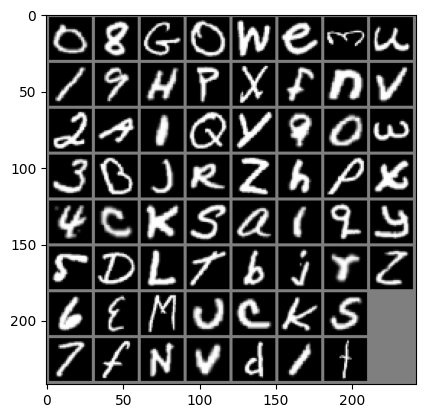

0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z


In [3]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (2, 1, 0)))
    plt.show()

images = []
for cls in classes.values():
    for img, label in train_set:
        if label == cls:            
            images.append(img)
            break

imshow(torchvision.utils.make_grid(images))
print(' '.join(classes.keys()))

## CNN Definition

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training

In [5]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        # if i % 2000 == 1999: # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0

    print(f"Epoch {epoch}: loss: {running_loss}")

print('Finished Training')

Epoch 0: loss: 78363.7495295882
Epoch 1: loss: 59806.18768270979
Epoch 2: loss: 57023.81734928678
Epoch 3: loss: 55554.722363362256
Epoch 4: loss: 54628.46065922377
Epoch 5: loss: 53887.08027569913
Epoch 6: loss: 53335.38137146895
Epoch 7: loss: 52900.16096008809
Epoch 8: loss: 52478.92192284932
Epoch 9: loss: 52096.02359314767
Finished Training


## Saving trained network

In [6]:
torch.save(net.state_dict(), PATH)

## Loading trained network

In [7]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Testing the network

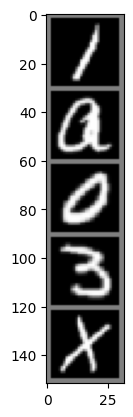

True Label:  I a 0 3 X
Predicted:  1 a 0 3 X


In [8]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('True Label: ', ' '.join(get_class_name(label) for label in labels))

outputs = net(images)
_, predicted_labels = torch.max(outputs, 1)

print('Predicted: ', ' '.join(get_class_name(label) for label in predicted_labels))

### Overall Accuracy

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 85 %


### Per class prediction

In [10]:
correct_pred = {classname: 0 for classname in classes.keys()}
total_pred = {classname: 0 for classname in classes.keys()}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[get_class_name(label)] += 1
            total_pred[get_class_name(label)] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 69.3 %
Accuracy for class: 1     is 95.2 %
Accuracy for class: 2     is 95.6 %
Accuracy for class: 3     is 99.1 %
Accuracy for class: 4     is 97.7 %
Accuracy for class: 5     is 94.2 %
Accuracy for class: 6     is 98.2 %
Accuracy for class: 7     is 99.2 %
Accuracy for class: 8     is 96.7 %
Accuracy for class: 9     is 97.9 %
Accuracy for class: A     is 96.5 %
Accuracy for class: B     is 94.6 %
Accuracy for class: C     is 92.8 %
Accuracy for class: D     is 86.4 %
Accuracy for class: E     is 94.6 %
Accuracy for class: F     is 70.8 %
Accuracy for class: G     is 84.8 %
Accuracy for class: H     is 94.0 %
Accuracy for class: I     is 45.8 %
Accuracy for class: J     is 83.2 %
Accuracy for class: K     is 83.8 %
Accuracy for class: L     is 91.5 %
Accuracy for class: M     is 98.2 %
Accuracy for class: N     is 97.4 %
Accuracy for class: O     is 65.9 %
Accuracy for class: P     is 95.9 %
Accuracy for class: Q     is 82.6 %
Accuracy for class: R     is

## Getting random captcha

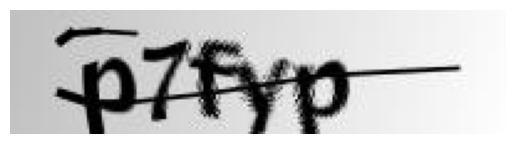

p7fyp


In [11]:
captchas = os.listdir('./captcha_dataset')
def get_random_captcha():
    selected_captcha = captchas[random.randint(0, len(captchas))]
    solution = selected_captcha[0:-4]

    image_path = os.path.join("./captcha_dataset", selected_captcha)
    image = plt.imread(image_path)
    return image, solution

captcha, solution = get_random_captcha()
plt.imshow(captcha)
plt.axis('off')
plt.show()
print(solution)

### Processing captcha and displaying new images

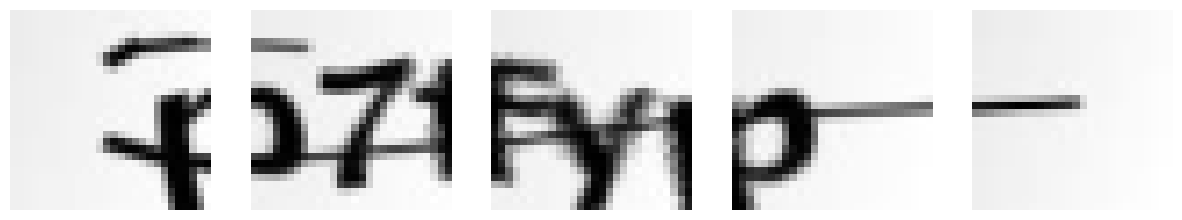

In [12]:
def process_captcha(captcha, break_into: int):
    """Breaks captcha into specified number of pieces and resizes it to 28x28 images"""
    flattened_captcha = np.mean(captcha, axis=2)
    broken_images = []
    starting = 0
    step = int(200 / break_into)
    ending = step
    for _ in range(break_into):
        piece = flattened_captcha[:, starting: ending]
        piece = piece[np.newaxis, :, :]
        piece = torch.Tensor(piece)
        piece = T.Resize(size = (28, 28), antialias=True)(piece)

        broken_images.append(piece.numpy())
        starting += step
        ending += step
    return torch.Tensor(np.array(broken_images))

broken_images = process_captcha(captcha, 5)

# Plot new broken images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, part in enumerate(broken_images):
    axs[i].imshow(part.numpy().reshape(28,28), cmap='gray')
    axs[i].axis('off')

## Predicting the Captcha

In [13]:
with torch.no_grad():
    prediction = []
    outputs = net(broken_images)
    _, predicted = torch.max(outputs.data, 1)
    
print('Predicted:', ''.join(get_class_name(label) for label in predicted))
print(f'Actual: {solution}')

Predicted: 11111
Actual: p7fyp
